In [30]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from collections import defaultdict

from scipy.stats import kruskal, norm
from scipy import stats
import pandas as pd
from statsmodels.stats.multitest import multipletests

In [31]:
## Simple recursive approach
def compute_AALC(d):
    if 'accuracy_test' in d:
        acc_list = d['accuracy_test']
        d['aalc'] = np.mean(acc_list)
    else:
        for v in d.values():
            compute_AALC(v)
    return d

## Rank experiments based on AALC
def rank_experiments(d, config):
    results = []
    for strategy, strategy_data in d[config].items():
        for acquisition, acquisition_data in strategy_data.items():
            for budget, budget_data in acquisition_data.items():
                for seed, seed_data in budget_data.items():
                    aalc = seed_data.get('aalc')
                    if aalc is not None:
                        name = f"{strategy}_{acquisition}_{budget}_{seed}"
                        results.append((name, aalc))
    # Sort by aalc descending
    results.sort(key=lambda x: x[1], reverse=True)
    return results

def get_average_ranks_group(loaded, config):
    # 1) Flatten and rank all (experiment+seed) pairs
    flat = []
    for strategy in loaded[config]:
        for acquisition in loaded[config][strategy]:
            for budget in loaded[config][strategy][acquisition]:
                for seed, data in loaded[config][strategy][acquisition][budget].items():
                    key = f"{strategy}_{acquisition}_{budget}_{seed}"
                    flat.append((key, data['aalc']))

    # sort by descending AALC, assign global rank 1…N
    flat_sorted = sorted(flat, key=lambda x: x[1], reverse=True)
    flat_ranks = { name: rank
                for rank, (name, _) in enumerate(flat_sorted, start=1) }

    # 2) Group by experiment (without seed) and average those ranks
    groups = defaultdict(list)
    for name, rank in flat_ranks.items():
        # remove the final "_seed" suffix
        exp_base = name.rsplit('_', 1)[0]
        groups[exp_base].append(rank)

    avg_ranks = [(exp, np.mean(ranks)) for exp, ranks in groups.items()]
    avg_ranks_sorted = sorted(avg_ranks, key=lambda x: x[1])

    # === Print results ===
    print("=== Global ranks (experiment_seed) ===")
    for name, aalc in flat_sorted[:10]:  # top 10 for example
        print(f"{name:30s}  aalc={aalc:.4f}, rank={flat_ranks[name]}")

    print("\n=== Average rank per experiment ===")
    for exp, avg in avg_ranks_sorted:
        print(f"{exp:30s}  avg_rank={avg:.2f}")

    return groups, flat

def calculate_krusal(groups):
    rank_per_group = list(groups.values())
    group_names    = list(groups.keys())

    print("=== Kruskal–Wallis test ===")
    for i, (name, ranks) in enumerate(zip(group_names, rank_per_group), 1):
        print(f"Group {i} ({name}): {ranks}")
    H, p = kruskal(*rank_per_group)
    print(f"\nKruskal–Wallis H = {H:.3f}, p = {p:.3f}")

def calculate_posthoc(groups):
    # ----- Kruskal‑Wallis (global test) -----
    values = np.concatenate(list(groups.values()))
    labels = np.concatenate([[name]*len(vals) for name, vals in groups.items()])
    grouped_values = [np.array(groups[name]) for name in groups]
    kw_stat, kw_p = stats.kruskal(*grouped_values)
    print(f"\nKruskal-Wallis test: H = {kw_stat:.3f}, p = {kw_p:.3f}")

    # ----- Dunn's test (post-hoc) -----
    N = len(values)
    V = N*(N+1)/12  # rank variance
    # Rank all observations
    ranks = stats.rankdata(values, method='average')
    # Map ranks to groups
    rank_groups = {name: ranks[labels == name] for name in groups}
    mean_ranks = {name: r.mean() for name, r in rank_groups.items()}
    n_i = {name: len(vals) for name, vals in groups.items()}

    names = list(groups.keys())
    m = len(names)
    p_raw = []
    pairs = []
    # Pairwise Z and p
    for i in range(m):
        for j in range(i+1, m):
            ni, nj = n_i[names[i]], n_i[names[j]]
            denom = np.sqrt(V * (1/ni + 1/nj))
            z = abs(mean_ranks[names[i]] - mean_ranks[names[j]]) / denom
            p = 2 * (1 - norm.cdf(z))
            pairs.append((names[i], names[j]))
            p_raw.append(p)

    # Holm correction
    p_adj = multipletests(p_raw, method='holm')[1]

    # Build adjusted p‑value matrix
    adj_matrix = np.full((m, m), np.nan)
    k = 0
    for i in range(m):
        for j in range(i+1, m):
            adj_matrix[i, j] = p_adj[k]
            adj_matrix[j, i] = p_adj[k]
            k += 1

    df_adj = pd.DataFrame(adj_matrix, index=names, columns=names)
    print("\n=== Dunn's test (post-hoc) ===")
    print("Pairwise adjusted p-values:")
    print(df_adj.round(3))

    return df_adj, mean_ranks

def get_categories(df_adj):
    print("\n=== Dunn's test (post-hoc) ===")
    print("Pairwise adjusted p-values:")
    # create a boolean mask for the upper triangle
    mask = np.triu(np.ones(df_adj.shape), k=1).astype(bool)

    # stack only those entries, then filter
    sig_df = (
        df_adj.where(mask)
            .stack()
            .reset_index()
            .rename(columns={'level_0':'Group1', 'level_1':'Group2', 0:'p_adj'})
            .query('p_adj < 0.05')
    )
    print(sig_df)

def sort_methods(df_adj, mean_ranks, alpha=0.05):
    # alpha = 0.05

    # sort methods from best (lowest rank) to worst (highest rank)
    methods = sorted(mean_ranks, key=lambda m: mean_ranks[m])

    # container for letter assignments
    letter_groups = {}
    current_letter = ord('A')

    for m in methods:
        # try to fit m into an existing letter
        for letter in sorted(set(letter_groups.values())):
            group_mates = [mm for mm, lt in letter_groups.items() if lt == letter]
            # check that m is NOT significantly different from *any* of these
            if all(df_adj.loc[m, mm] > alpha for mm in group_mates):
                letter_groups[m] = letter
                break
        else:
            # if we didn’t break, assign a new letter
            letter_groups[m] = chr(current_letter)
            current_letter += 1

    # build a summary table
    summary = pd.DataFrame({
        'Mean Rank': [mean_ranks[m] for m in methods],
        'Group':     [letter_groups[m] for m in methods]
    }, index=methods)

    print(summary)
    return summary

def get_summary(summary, flat):
    # 1) Re‐group the raw AALC values by experiment (no seed)
    exp_vals = defaultdict(list)
    for name, aalc in flat:          # flat from your earlier code
        exp = name.rsplit('_', 1)[0]  # drop the final "_<seed>"
        exp_vals[exp].append(aalc)

    # 2) Bootstrap to get mean ± 95% CI
    n_boot = 10_000
    rng    = np.random.default_rng(0)  # for reproducibility

    boot_means = {}
    ci_lower   = {}
    ci_upper   = {}
    for exp, vals in exp_vals.items():
        arr = np.array(vals)
        # draw B x len(arr) resamples
        samples = rng.choice(arr, size=(n_boot, len(arr)), replace=True)
        means   = samples.mean(axis=1)
        boot_means[exp] = arr.mean()
        ci_lower[exp], ci_upper[exp] = np.percentile(means, [2.5, 97.5])

    # 3) Build a DataFrame and merge with your existing summary
    ci_df = pd.DataFrame({
        'Mean AALC': pd.Series(boot_means),
        'CI Lower':  pd.Series(ci_lower),
        'CI Upper':  pd.Series(ci_upper),
    })

    # suppose `summary` is your DataFrame indexed by experiment
    # with columns like ['Mean Rank','Group',…]
    final = summary.join(ci_df)

    print(final)
    return final

def plot(final, dataset, configuration, name_plot="test"):
    # --- prepare data ---
    # order experiments by ascending Mean Rank
    order   = final['Mean Rank'].sort_values().index
    df_plot = final.loc[order].reset_index().rename(columns={'index': 'Experiment'})

    df_plot['Experiment'] = (
    df_plot['Experiment']
           .str.replace('_01', '_0.1', regex=False)
           .str.replace('midropout', 'batchbald', regex=False)
           .str.replace('_random', '', regex=False)
           .str.replace('threshold', 'thresholding', regex=False)
    )
    
    # extract plotting arrays
    experiments = df_plot['Experiment']
    means       = df_plot['Mean AALC']
    ci_lower    = df_plot['CI Lower']
    ci_upper    = df_plot['CI Upper']
    # symmetric error‐bars
    errors = [means - ci_lower, ci_upper - means]
    groups      = df_plot['Group']

    # --- assign colors by group using Set1 palette ---
    palette = plt.get_cmap('Set1').colors
    unique_groups  = groups.unique()
    group_color_map = {g: palette[i % len(palette)]
                       for i, g in enumerate(unique_groups)}
    bar_colors     = [group_color_map[g] for g in groups]

    # figure size (inches)
    if configuration == "area":
        width_in  = 2.8
        height_in = 2.6
    else:
        width_in  = 2.8
        height_in = 3.8

    # global rcParams
    plt.rcParams.update({
        'font.size': 8,
        'font.family': 'serif',
        'axes.titlesize': 8,
        'axes.labelsize': 8,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        'text.usetex': True,
        'font.serif': ['Times'],
    })

    # --- plotting ---
    fig, ax = plt.subplots(figsize=(width_in, height_in))
    ax.barh(experiments, means,
            xerr=errors,
            capsize=0,
            )
    
    # Hide all spines except the bottom (x-axis)
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    # axis labels & limits
    # ax.set_ylabel('Experiment')     # now vertical axis is your categories
    ax.set_xlabel('Mean nAUC')

    if dataset == "build6k":
        x_lims = (0.7, 0.82)
    else:
        x_lims = (0.6, 0.75)
    ax.set_xlim(x_lims)

    # invert so best (lowest rank) is at top, if desired
    ax.invert_yaxis()

    # ensure ticks and labels are horizontal
    ax.xaxis.set_tick_params(rotation=0)
    ax.yaxis.set_tick_params(rotation=0)
    ax.tick_params(axis='x', pad=4)  # default is ~4–6
    ax.margins(y=0.02)

    # ax.set_title('build6k distance')

    # # --- custom legend for Group ---
    # legend_handles = [
    #     mpatches.Patch(color=group_color_map[g], label=g)
    #     for g in unique_groups
    # ]
    # ax.legend(handles=legend_handles, title='Group', loc='best')

    plt.tight_layout()
    plt.savefig(name_plot, bbox_inches='tight', dpi=300)
    plt.show()
    

In [32]:
def main():

    # Inputs
    dataset = "nieman17k"
    path_results = dataset + ".npy"
    configuration = "area"
    name_plot = "results" + "_" + dataset + "_" + configuration + ".pdf"
    # (build6k [0.7, 0.82] ) (niemam17k [0.6, 0.75])

    # Load the json file
    loaded = np.load(path_results, allow_pickle=True).item()
    print("loaded!")

    # Compute AALC
    aalc_dict = compute_AALC(loaded)

    # Compute rankings
    rankings = rank_experiments(loaded, configuration)
    for name, score in rankings:
        print(f"{name}: {score:.4f}")

    # Get average ranks
    groups, flat = get_average_ranks_group(loaded, configuration)

    # Calculate Kruskal-Wallis test
    calculate_krusal(groups)

    # Calculate Dunn's post-hoc test
    df_adj, mean_ranks = calculate_posthoc(groups)

    # Get significant categories
    get_categories(df_adj)

    # Sort methods
    summary = sort_methods(df_adj, mean_ranks, alpha=0.05)

    # Get summary
    final = get_summary(summary, flat)

    # Plot results
    plot(final, dataset, configuration, name_plot=name_plot)

loaded!
greedy_midropout_inf_2: 0.7119
greedy_midropout_inf_4: 0.7116
greedy_midropout_inf_1: 0.7106
greedy_midropout_inf_3: 0.7089
greedy_midropout_inf_5: 0.7075
greedy_badge_inf_1: 0.7029
greedy_badge_inf_3: 0.6989
greedy_badge_inf_5: 0.6953
greedy_coreset_inf_5: 0.6947
greedy_badge_inf_4: 0.6944
random_random_inf_2: 0.6918
greedy_midropout_101_5: 0.6916
greedy_coreset_inf_4: 0.6889
greedy_midropout_101_2: 0.6884
greedy_midropout_101_4: 0.6883
greedy_badge_inf_2: 0.6882
greedy_midropout_101_3: 0.6881
greedy_midropout_101_1: 0.6881
greedy_coreset_inf_3: 0.6863
random_random_inf_3: 0.6852
random_random_inf_5: 0.6852
random_random_inf_1: 0.6848
greedy_coreset_inf_2: 0.6844
greedy_badge_101_5: 0.6837
greedy_coreset_inf_1: 0.6805
random_random_inf_4: 0.6797
threshold_midropout_101_1: 0.6789
greedy_badge_101_2: 0.6785
threshold_midropout_101_4: 0.6768
threshold_midropout_101_3: 0.6764
threshold_midropout_101_5: 0.6748
random_random_101_1: 0.6737
threshold_midropout_101_2: 0.6730
random_ran

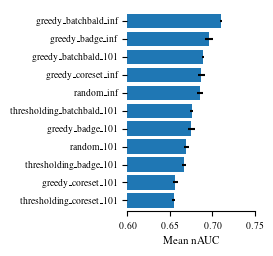

In [33]:
main()